In [ ]:
# IMDB Data Preparation

Author: Sunil Kuruba

In [ ]:
# Prerequisite
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [ ]:
# Load CSV
df = pd.read_csv('tmdb_enriched_movies.csv')

# Clean column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
df.columns

Index(['movie_id', 'imdb_id', 'title', 'vote_average', 'vote_count', 'status',
       'release_date', 'budget', 'revenue', 'popularity', 'runtime',
       'language', 'genres', 'production_companies', 'director', 'top_cast',
       'keywords'],
      dtype='object')

In [23]:
df.head()

,movie_id,imdb_id,title,vote_average,vote_count,status,release_date,budget,revenue,popularity,runtime,language,genres,production_companies,director,top_cast,keywords
0,27205,tt1375666,Inception,8.369,37309,Released,2010-07-15,160000000,839030630,26.3533,148,en,"Action, Science Fiction, Adventure","Legendary Pictures, Syncopy, Warner Bros. Pict...",Christopher Nolan,"Leonardo DiCaprio, Joseph Gordon-Levitt, Ken W...","rescue, mission, dreams, airplane, paris, fran..."
1,157336,tt0816692,Interstellar,8.453,36903,Released,2014-11-05,165000000,746606706,44.7344,169,en,"Adventure, Drama, Science Fiction","Legendary Pictures, Syncopy, Lynda Obst Produc...",Christopher Nolan,"Matthew McConaughey, Anne Hathaway, Michael Caine","rescue, future, spacecraft, race against time,..."
2,155,tt0468569,The Dark Knight,8.519,33688,Released,2008-07-16,185000000,1004558444,34.4859,152,en,"Drama, Action, Crime, Thriller","Warner Bros. Pictures, Legendary Pictures, Syn...",Christopher Nolan,"Christian Bale, Heath Ledger, Aaron Eckhart","joker, sadism, chaos, secret identity, crime f..."
3,19995,tt0499549,Avatar,7.588,32126,Released,2009-12-15,237000000,2923706026,32.3911,162,en,"Action, Adventure, Fantasy, Science Fiction","Dune Entertainment, Lightstorm Entertainment, ...",James Cameron,"Sam Worthington, Zoe Saldaña, Sigourney Weaver","paraplegic, attachment to nature, culture clas..."
4,24428,tt0848228,The Avengers,7.735,31521,Released,2012-04-25,220000000,1518815515,35.1429,143,en,"Science Fiction, Action, Adventure",Marvel Studios,Joss Whedon,"Robert Downey Jr., Chris Evans, Mark Ruffalo","new york city, superhero, shield, based on com..."


In [ ]:
# Convert data types
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
num_cols = ['budget', 'revenue', 'runtime', 'vote_average', 'vote_count']
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df.isna().sum()

movie_id                   0
imdb_id                 2786
title                      0
vote_average               0
vote_count                 0
status                     0
release_date            1154
budget                     0
revenue                    0
popularity                 0
runtime                    0
language                   0
genres                  1116
production_companies    2282
director                1208
top_cast                 919
keywords                3111
dtype: int64

In [ ]:

# Handle missing values
df.dropna(subset=['budget', 'revenue'], inplace=True)

# Strip and lowercase text fields
text_cols = ['language', 'genres', 'production_companies', 'top_cast', 'keywords', 'status']
for col in text_cols:
    df[col] = df[col].astype(str).str.strip().str.lower()


In [25]:

# Split multi-value columns
df['genres_list'] = df['genres'].str.split(', ')
df['top_cast_list'] = df['top_cast'].str.split(', ')
df['keywords_list'] = df['keywords'].str.split(', ')

df[['genres', 'genres_list', 'top_cast', 'top_cast_list', 'keywords', 'keywords_list']].head()

,genres,genres_list,top_cast,top_cast_list,keywords,keywords_list
0,"Action, Science Fiction, Adventure","[Action, Science Fiction, Adventure]","Leonardo DiCaprio, Joseph Gordon-Levitt, Ken W...","[Leonardo DiCaprio, Joseph Gordon-Levitt, Ken ...","rescue, mission, dreams, airplane, paris, fran...","[rescue, mission, dreams, airplane, paris, fra..."
1,"Adventure, Drama, Science Fiction","[Adventure, Drama, Science Fiction]","Matthew McConaughey, Anne Hathaway, Michael Caine","[Matthew McConaughey, Anne Hathaway, Michael C...","rescue, future, spacecraft, race against time,...","[rescue, future, spacecraft, race against time..."
2,"Drama, Action, Crime, Thriller","[Drama, Action, Crime, Thriller]","Christian Bale, Heath Ledger, Aaron Eckhart","[Christian Bale, Heath Ledger, Aaron Eckhart]","joker, sadism, chaos, secret identity, crime f...","[joker, sadism, chaos, secret identity, crime ..."
3,"Action, Adventure, Fantasy, Science Fiction","[Action, Adventure, Fantasy, Science Fiction]","Sam Worthington, Zoe Saldaña, Sigourney Weaver","[Sam Worthington, Zoe Saldaña, Sigourney Weaver]","paraplegic, attachment to nature, culture clas...","[paraplegic, attachment to nature, culture cla..."
4,"Science Fiction, Action, Adventure","[Science Fiction, Action, Adventure]","Robert Downey Jr., Chris Evans, Mark Ruffalo","[Robert Downey Jr., Chris Evans, Mark Ruffalo]","new york city, superhero, shield, based on com...","[new york city, superhero, shield, based on co..."


In [ ]:

# Remove duplicates
df.drop_duplicates(subset=['movie_id', 'title'], inplace=True)

# Remove invalid rows
df = df[(df['budget'] >= 0) & (df['revenue'] >= 0) & (df['runtime'] > 0)]

# Remove unwanted columns 
df.drop(['imdb_id', 'status'], axis=1, inplace=True)

# Final preview
df.head()

/var/folders/0t/nvsb9hb16cz3yyv_k6byz7yr0000gn/T/ipykernel_20266/3430085902.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset=['movie_id', 'title'], inplace=True)


,movie_id,title,vote_average,vote_count,release_date,budget,revenue,popularity,runtime,language,genres,production_companies,director,top_cast,keywords,genres_list,top_cast_list,keywords_list
0,27205,Inception,8.369,37309,2010-07-15,160000000,839030630,26.3533,148,en,"Action, Science Fiction, Adventure","Legendary Pictures, Syncopy, Warner Bros. Pict...",Christopher Nolan,"Leonardo DiCaprio, Joseph Gordon-Levitt, Ken W...","rescue, mission, dreams, airplane, paris, fran...","[Action, Science Fiction, Adventure]","[Leonardo DiCaprio, Joseph Gordon-Levitt, Ken ...","[rescue, mission, dreams, airplane, paris, fra..."
1,157336,Interstellar,8.453,36903,2014-11-05,165000000,746606706,44.7344,169,en,"Adventure, Drama, Science Fiction","Legendary Pictures, Syncopy, Lynda Obst Produc...",Christopher Nolan,"Matthew McConaughey, Anne Hathaway, Michael Caine","rescue, future, spacecraft, race against time,...","[Adventure, Drama, Science Fiction]","[Matthew McConaughey, Anne Hathaway, Michael C...","[rescue, future, spacecraft, race against time..."
2,155,The Dark Knight,8.519,33688,2008-07-16,185000000,1004558444,34.4859,152,en,"Drama, Action, Crime, Thriller","Warner Bros. Pictures, Legendary Pictures, Syn...",Christopher Nolan,"Christian Bale, Heath Ledger, Aaron Eckhart","joker, sadism, chaos, secret identity, crime f...","[Drama, Action, Crime, Thriller]","[Christian Bale, Heath Ledger, Aaron Eckhart]","[joker, sadism, chaos, secret identity, crime ..."
3,19995,Avatar,7.588,32126,2009-12-15,237000000,2923706026,32.3911,162,en,"Action, Adventure, Fantasy, Science Fiction","Dune Entertainment, Lightstorm Entertainment, ...",James Cameron,"Sam Worthington, Zoe Saldaña, Sigourney Weaver","paraplegic, attachment to nature, culture clas...","[Action, Adventure, Fantasy, Science Fiction]","[Sam Worthington, Zoe Saldaña, Sigourney Weaver]","[paraplegic, attachment to nature, culture cla..."
4,24428,The Avengers,7.735,31521,2012-04-25,220000000,1518815515,35.1429,143,en,"Science Fiction, Action, Adventure",Marvel Studios,Joss Whedon,"Robert Downey Jr., Chris Evans, Mark Ruffalo","new york city, superhero, shield, based on com...","[Science Fiction, Action, Adventure]","[Robert Downey Jr., Chris Evans, Mark Ruffalo]","[new york city, superhero, shield, based on co..."


## Exploratory Data Analysis

## Visualization 1 - Budget VS Revenue

This plot highlights a generally linear trend, indicating that higher budgets are often associated with higher revenues, as shown by the correlation line.

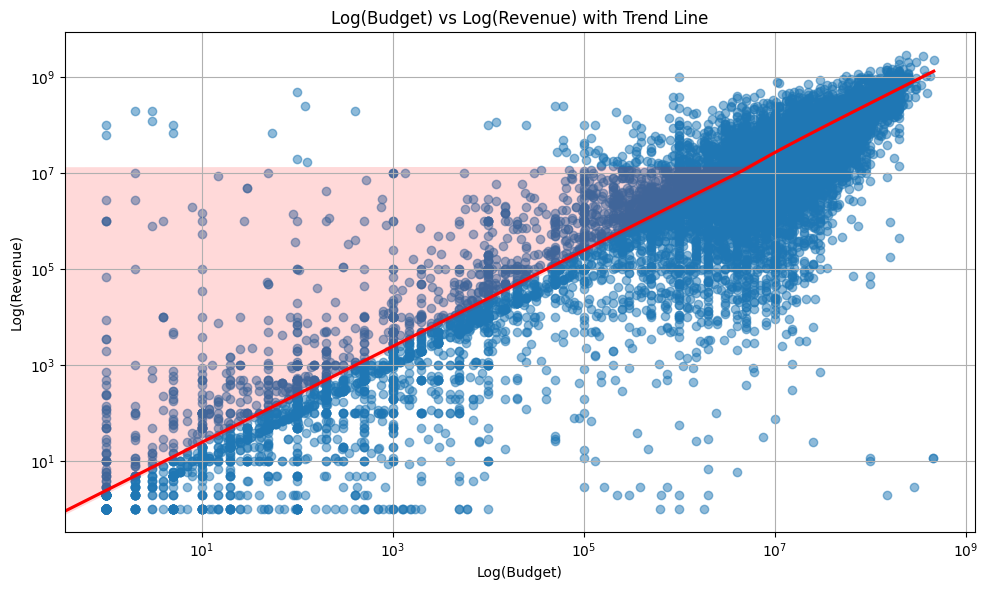

In [ ]:
# Scatter plot with regression line
plt.figure(figsize=(10,6))
sns.regplot(
    x='budget',
    y='revenue',
    data=df,
    scatter_kws={'alpha': 0.5},
    line_kws={'color': 'red'}
)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Log(Budget)')
plt.ylabel('Log(Revenue)')
plt.title('Log(Budget) vs Log(Revenue) with Corelation')
plt.grid(True)
plt.tight_layout()
plt.show()


## Visualization 2 - Top 10 Genres by Average Revenue

Adventure, Animation, Science Fiction, Fantasy, Family, and Action dominate the chart, each with average revenues above 100 million dollars. Other genres like Thriller, Comedy, War, and Crime have lower average earnings, though still notable.

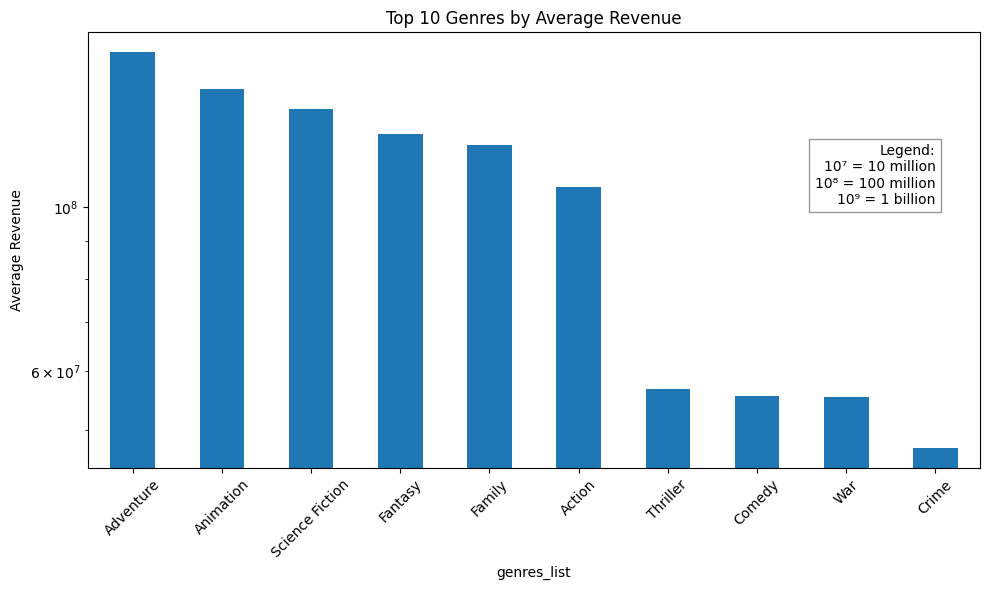

In [ ]:
# Explode genre lists
genre_revenue = df.explode('genres_list')
genre_avg_revenue = genre_revenue.groupby('genres_list')['revenue'].mean().sort_values(ascending=False).head(10)

genre_avg_revenue.plot(kind='bar', figsize=(10,6), title='Top 10 Genres by Average Revenue')
plt.yscale('log')
plt.ylabel('Average Revenue')
plt.xticks(rotation=45)

plt.text(
    x=9, y=1e8, 
    s='Legend:\n10⁷ = 10 million\n10⁸ = 100 million\n10⁹ = 1 billion',
    fontsize=10,
    ha='right',
    va='bottom',
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray')
)

plt.tight_layout()
plt.show()


## Visualization 3 - Number of Movies Released and Total Revenue Per year

There's a strong correlation between the number of movies released and the total industry revenue. The COVID-19 pandemic had a profound impact on both production and earnings. The dataset data is limited only till 2022, so we find a dead line after 2022.

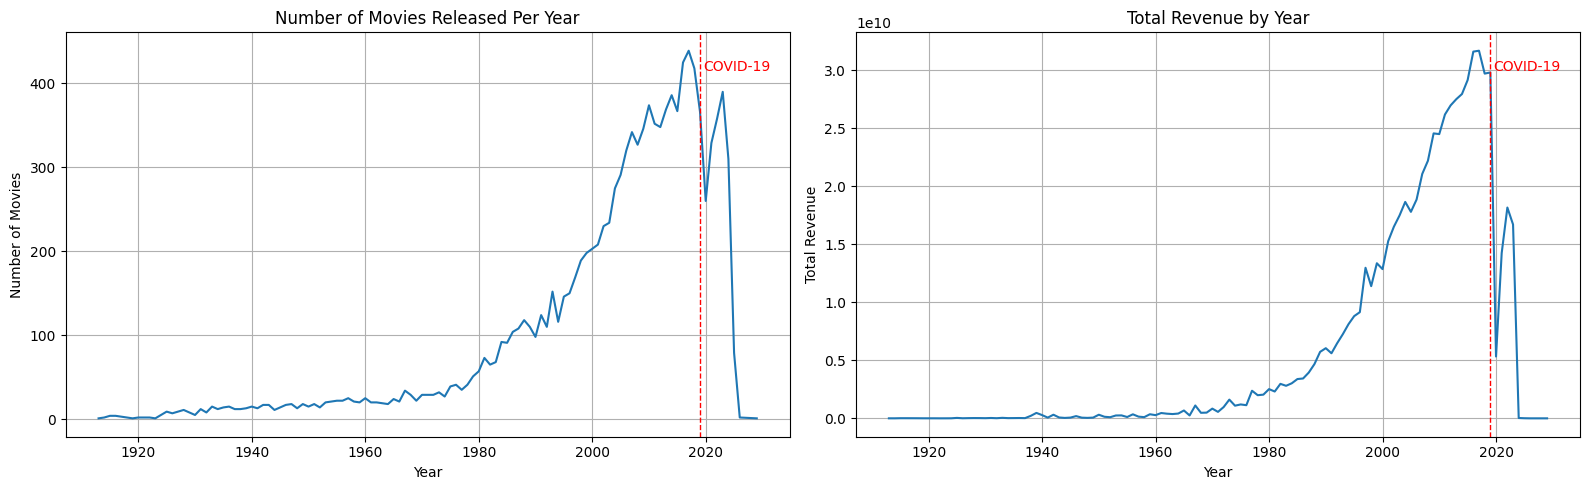

In [ ]:
# Make sure 'release_year' is in your DataFrame
df['release_year'] = df['release_date'].dt.year

# Create subplots
fig, axes = plt.subplots(ncols=2, figsize=(16, 5))

# Plot 1: Number of Movies Released
df['release_year'].value_counts().sort_index().plot(ax=axes[0], title='Number of Movies Released Per Year')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Number of Movies')
axes[0].grid(True)

# Add vertical line for 2019
axes[0].axvline(x=2019, color='red', linestyle='--', linewidth=1)
axes[0].text(2019 + 0.5, axes[0].get_ylim()[1]*0.9, 'COVID-19', color='red', fontsize=10)

# Plot 2: Total Revenue by Year
df.groupby('release_year')['revenue'].sum().plot(ax=axes[1], title='Total Revenue by Year')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Total Revenue')
axes[1].grid(True)

# Add vertical line and label
axes[1].axvline(x=2019, color='red', linestyle='--', linewidth=1)
axes[1].text(2019 + 0.5, axes[1].get_ylim()[1]*0.9, 'COVID-19', color='red', fontsize=10)

# Adjust layout
plt.tight_layout()
plt.show()



# Visualization 4 - Revenue Distribution by Genre

Adventure movies tend to have the highest median and upper quartile revenues, followed closely by Action and Thriller films. In contrast, genres like Drama and Romance show lower medians but still feature wide revenue ranges. The numerous dots above each box represent outliers, indicating that while the typical film may earn modest revenue, some films in each genre achieve exceptionally high box office success.

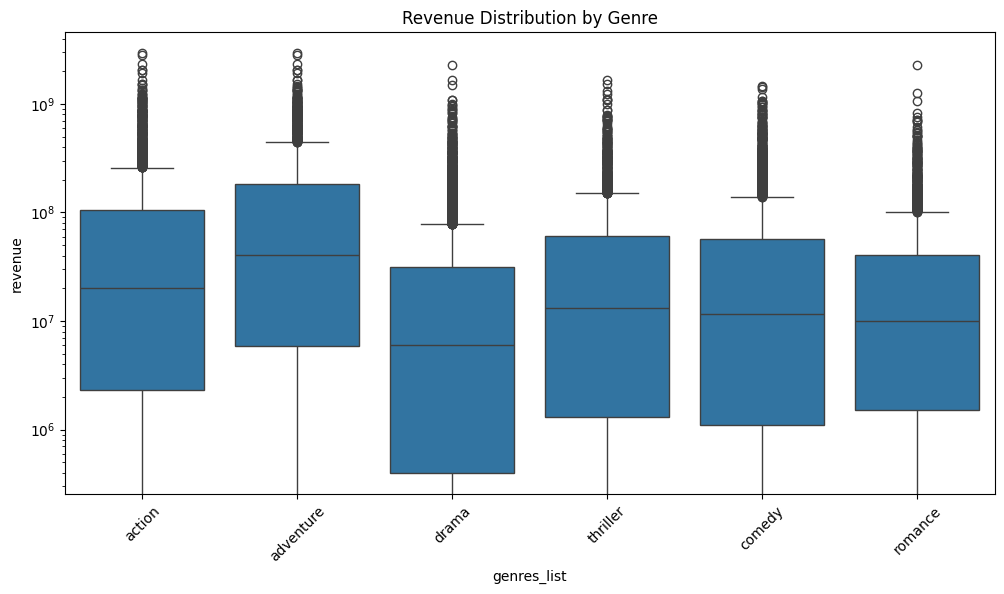

In [17]:
import seaborn as sns

# Plot only popular genres (optional filtering)
popular_genres = df.explode('genres_list')
popular_genres = popular_genres[popular_genres['genres_list'].isin(
    popular_genres['genres_list'].value_counts().head(6).index)]

plt.figure(figsize=(12,6))
sns.boxplot(x='genres_list', y='revenue', data=popular_genres)
plt.yscale('log')
plt.title('Revenue Distribution by Genre')
plt.xticks(rotation=45)
plt.show()


# Visualization 5 - Genre Trend Over the Years

From the plot, we observe that:
* Drama has consistently been the most released genre, peaking around 2015–2019 with over 200 films per year.
* Comedy and Thriller also show strong upward trends, especially from the 1980s onward.
* Action and Adventure genres saw significant growth in the 2000s and 2010s, aligning with the rise of blockbuster cinema.
* Romance maintained steady popularity but started declining in the late 2010s.
* There is a sharp drop in all genres after 2019, clearly indicating the impact of the COVID-19 pandemic on film production globally

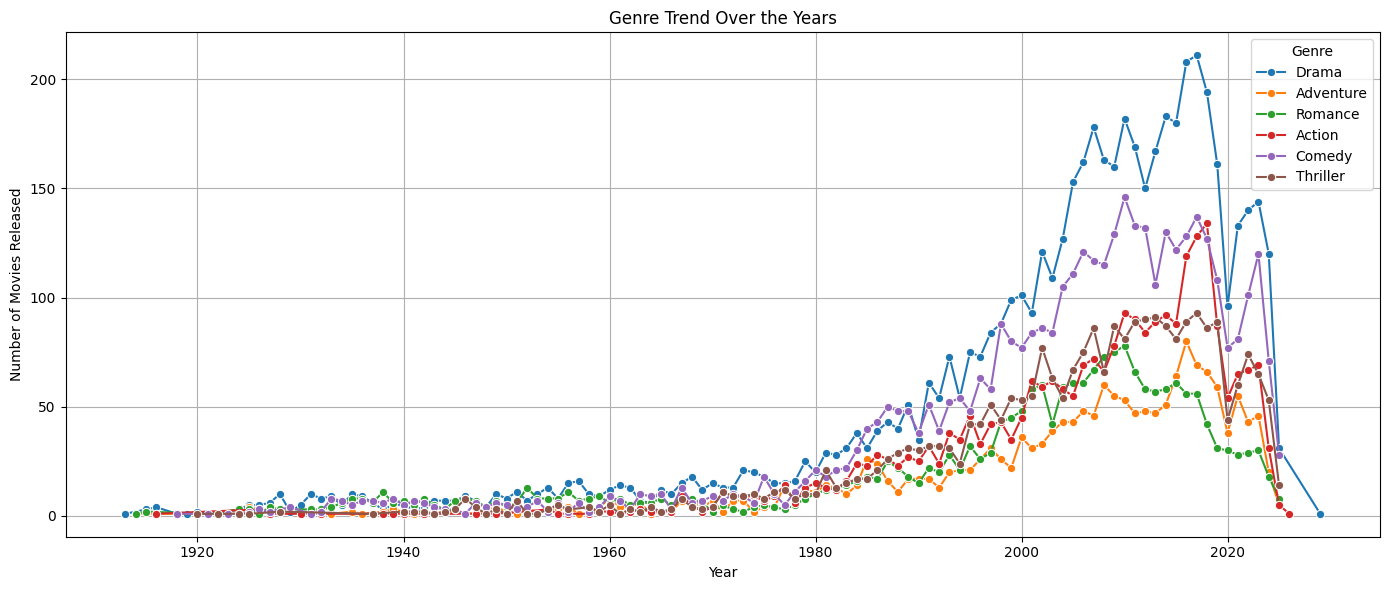

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure release_year and genre list exist
df['release_year'] = df['release_date'].dt.year
df_exploded = df.explode('genres_list')

# Filter to include only popular genres (optional)
top_genres = df_exploded['genres_list'].value_counts().head(6).index
df_filtered = df_exploded[df_exploded['genres_list'].isin(top_genres)]

# Group by year and genre to count number of movies
genre_trend = df_filtered.groupby(['release_year', 'genres_list']).size().reset_index(name='movie_count')

# Plot the trend
plt.figure(figsize=(14, 6))
sns.lineplot(data=genre_trend, x='release_year', y='movie_count', hue='genres_list', marker='o')

plt.title('Genre Trend Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Movies Released')
plt.grid(True)
plt.legend(title='Genre')
plt.tight_layout()
plt.show()


#  Visualization 6 - Profit vs Loss by Genre

This graph presents a comparative view of **genre-wise loss and profit rates** in the film industry. The **left plot** illustrates the proportion of movies that incurred a **loss** in each genre, with *History*, *Western*, and *War* genres topping the list—indicating that a significant share of films in these categories failed to recover their budget. On the **right plot**, we see the **profit rate** for each genre, with *Family*, *Adventure*, and *Action* films showing the highest probability of turning a profit. Interestingly, genres like *Documentary*, *TV Movie*, and *History* consistently appear at the lower end of the profit spectrum and higher end of the loss spectrum, suggesting these may be riskier investments from a financial perspective. This side-by-side visualization clearly demonstrates how profitability varies by genre and can guide production or investment decisions.

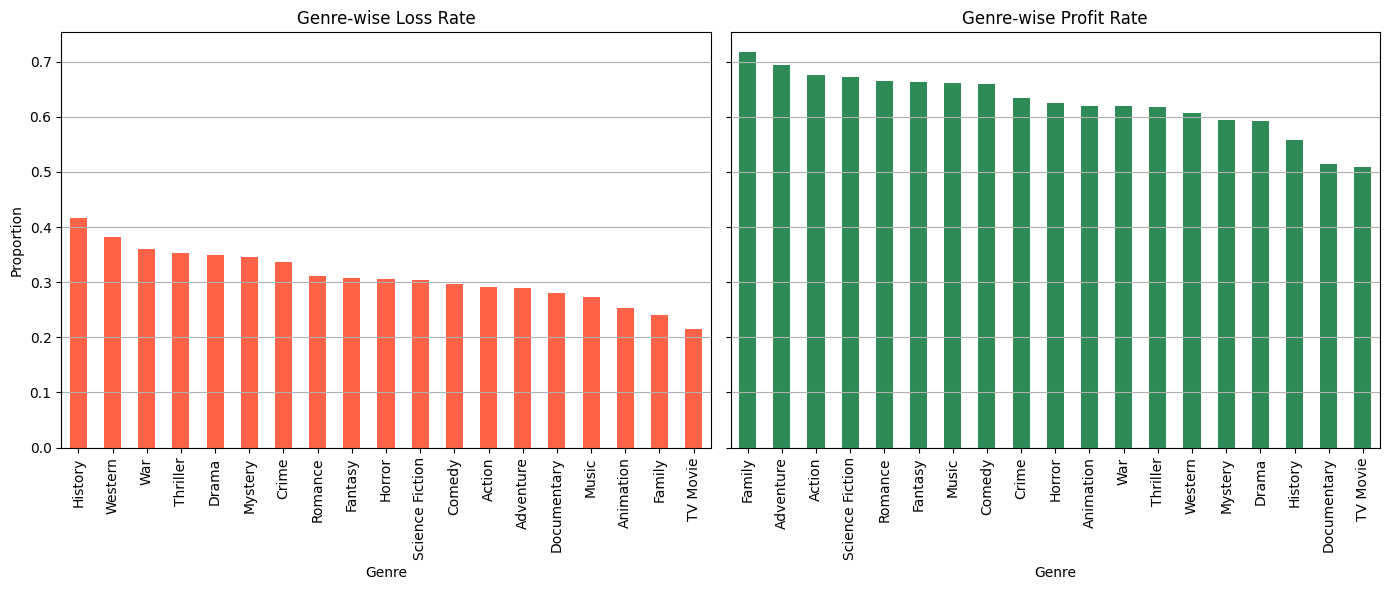

In [78]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Calculate profit
df['profit'] = df['revenue'] - df['budget']

# Step 2: Explode genres into individual rows
df_exploded = df.explode('genres_list')

# Step 3: Create loss and profit flags
df_exploded['is_loss'] = df_exploded['profit'] < 0
df_exploded['is_profit'] = df_exploded['profit'] > 0

# Step 4: Calculate percentage loss and profit per genre
loss_rate = df_exploded.groupby('genres_list')['is_loss'].mean()
profit_rate = df_exploded.groupby('genres_list')['is_profit'].mean()

# Step 5: Combine both into one DataFrame
rate_df = pd.DataFrame({
    'Loss Rate': loss_rate,
    'Profit Rate': profit_rate
})

rate_df_loss = rate_df.sort_values('Loss Rate', ascending=False)
rate_df_profit = rate_df.sort_values('Profit Rate', ascending=False)

# Step 6: Plot side-by-side bar plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Loss plot
rate_df_loss['Loss Rate'].plot(kind='bar', ax=axes[0], color='tomato')
axes[0].set_title('Genre-wise Loss Rate')
axes[0].set_ylabel('Proportion')
axes[0].set_xlabel('Genre')
axes[0].tick_params(axis='x', rotation=90)
axes[0].grid(axis='y')

# Profit plot
rate_df_profit['Profit Rate'].plot(kind='bar', ax=axes[1], color='seagreen')
axes[1].set_title('Genre-wise Profit Rate')
axes[1].set_xlabel('Genre')
axes[1].tick_params(axis='x', rotation=90)
axes[1].grid(axis='y')

plt.tight_layout()
plt.show()


#  Visualization 7 -  top 20 actors on average revenue-to-budget ratio

From the plot, we can see:

* Robert Shaw, Lin Shaye, and Shawnee Smith stand out with high average revenues, indicating that the movies they participated in typically generated substantial returns compared to their budgets.
* Olivia de Havilland and Clark Gable also show strong positive returns on relatively modest budgets.
* Several actors in the lower-left corner (e.g., Margaret Hamilton, Steve Landesberg) had low average budgets and revenues, suggesting lower overall commercial impact, but they still made the top 20 due to high revenue-to-budget efficiency in smaller productions.

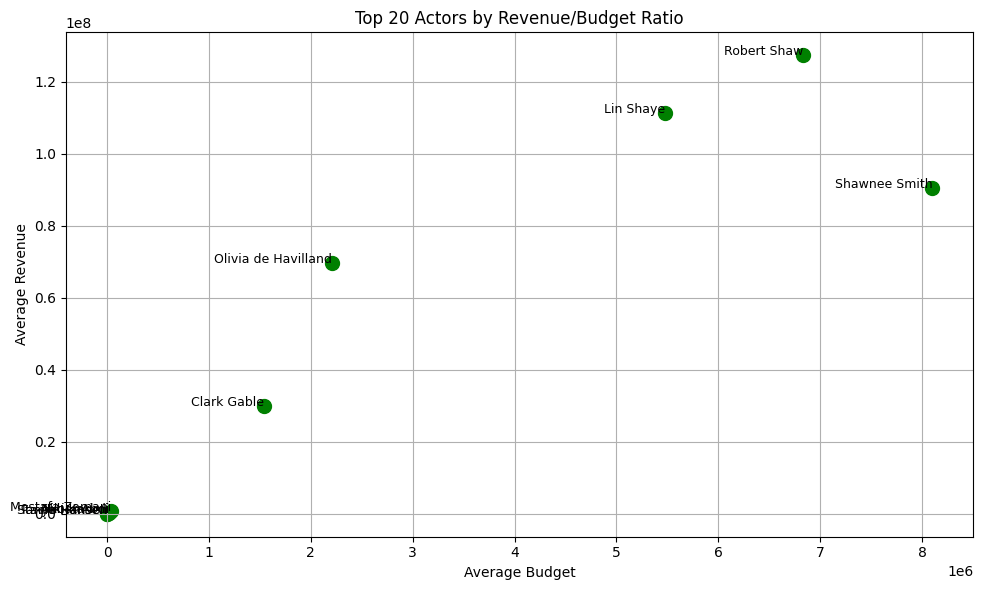

In [82]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 2: Explode top_cast_list
df_exploded = df_valid.explode('top_cast_list')

# Step 3: Group by actor and calculate average budget and revenue
actor_avg = df_exploded.groupby('top_cast_list').agg(
    avg_budget=('budget', 'mean'),
    avg_revenue=('revenue', 'mean'),
    movie_count=('budget', 'count')
)

# Optional: Filter to only actors with 5+ movies to avoid outliers
actor_avg = actor_avg[actor_avg['movie_count'] >= 5]

# Step 4: Sort and select top 20 by avg_revenue / avg_budget ratio
actor_avg['ratio'] = actor_avg['avg_revenue'] / actor_avg['avg_budget']
top10 = actor_avg.sort_values('ratio', ascending=False).head(10)

# Step 5: Plot
plt.figure(figsize=(10, 6))
plt.scatter(top10['avg_budget'], top10['avg_revenue'], color='green', s=100)

# Add actor name labels to each point
for actor, row in top10.iterrows():
    plt.text(row['avg_budget'], row['avg_revenue'], actor, fontsize=9, ha='right')

plt.xlabel('Average Budget')
plt.ylabel('Average Revenue')
plt.title('Top 20 Actors by Revenue/Budget Ratio')
plt.grid(True)
plt.tight_layout()
plt.show()
